# Deep Hedging AI
### Vanilla Deep Hedging engine reference implementation with dynamic training update.
Hans Buehler, June 30 2022


Deep Hedging AI says hello to Tensorflow version 2.7.0


## Deep Hedging in Black \& Scholes World

Deep Hedging Engine: first of 400 epochs for 10000 samples / 1000 validation samples started ... 

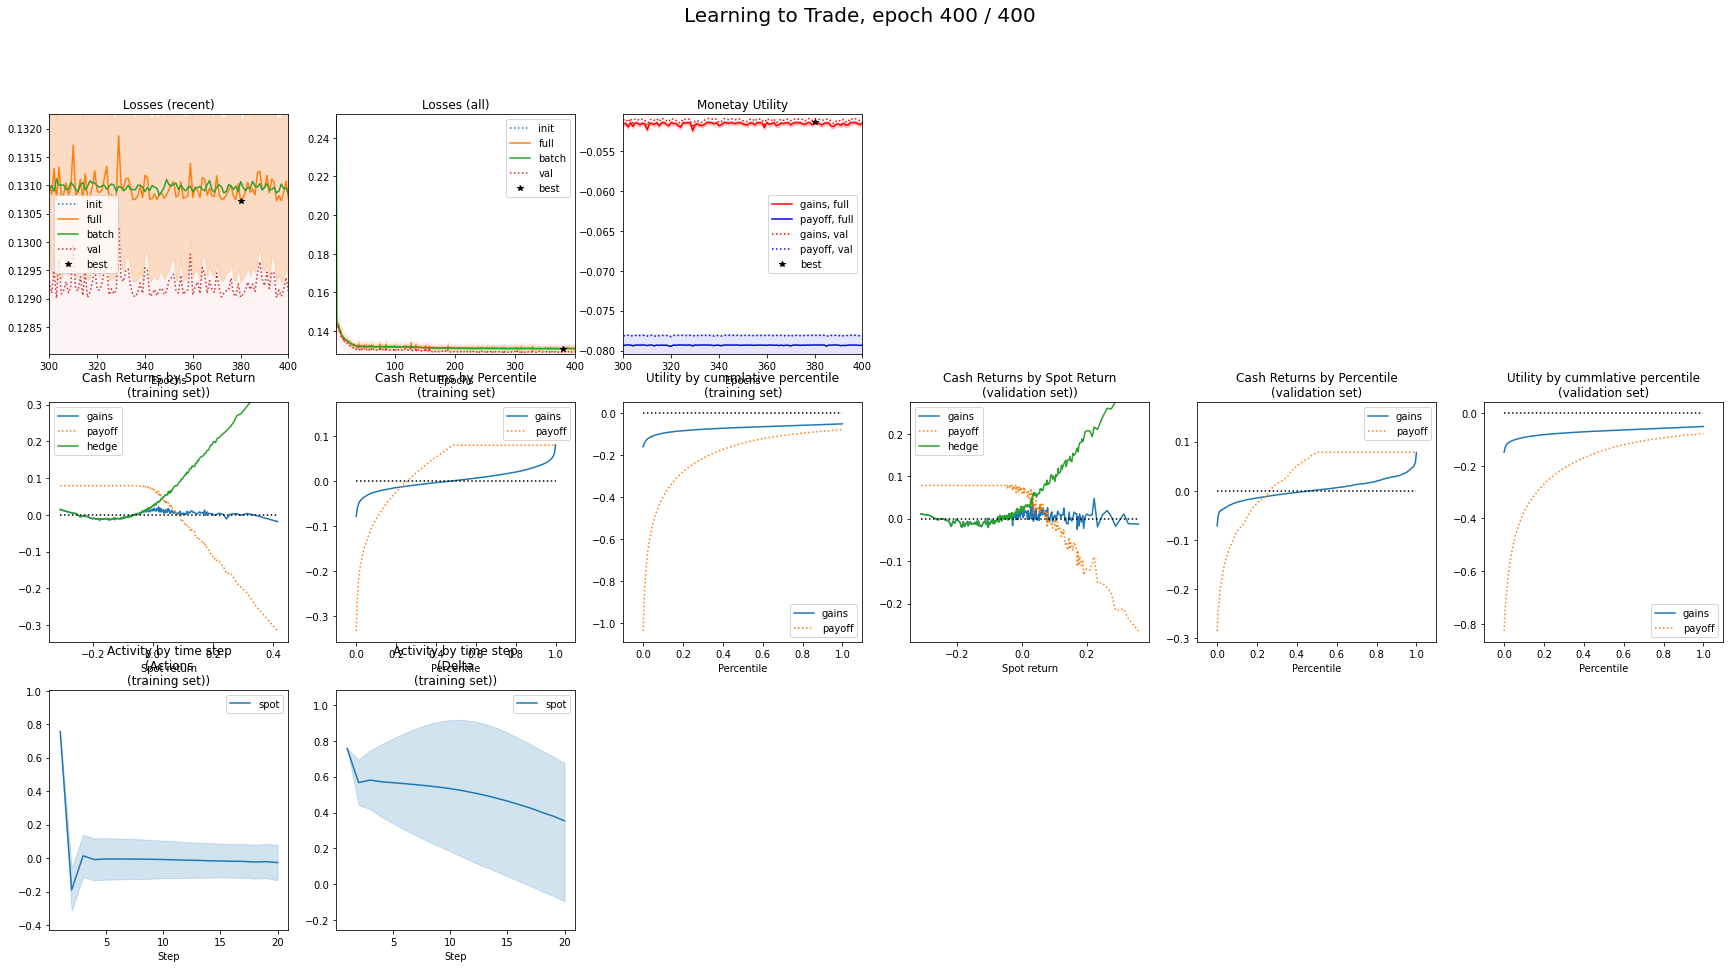

Training 400/400 epochs; 10000 samples; 1000 validation samples batch size 32 | initial loss 2.83487 (0.0668206), full 0.130761 (0.00143816), best 0.130723 (0.0668206), batch 0.13085, val 0.12912 (0.00415263). Best batch 379 | time elapsed 39:22; estimated time remaining 5s  s    
 Status: Ran all 400 epochs

Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions', 'deltas'])
Config usage report
config.gym.agent.network['activation'] = softplus # Network activation function; default: relu
config.gym.agent.network['depth'] = 3 # Network depth; default: 3
config.gym.agent.network['width'] = 20 # Network width; default: 20
config.gym.agent['agent_type'] = feed_forward #  Default: feed_forward
config.gym.agent['features'] = ['price', 'delta', 'time_left'] # Named features the agent uses from the environment; default: ['price', 'delta', 'time_left']
config.gym.environment['softclip_hinge_softness'] = 1.0 # Specifies

In [1]:
"""
When working on the code base, activate below code:

import imp
import deephedging.base as base
imp.reload(base)
import deephedging.world as world
imp.reload(world)
import deephedging.agents as agents
imp.reload(agents)
import deephedging.objectives as objectives
imp.reload(objectives)
import deephedging.gym as gym
imp.reload(gym)
import deephedging.trainer as trainer
imp.reload(trainer)
"""

print("Deep Hedging AI says hello to ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "exp2"
config.gym.objective.lmbda = 10.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.train.run_eagerly = False
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()


## Deep Hedging in simple Stochastic Volatility

Deep Hedging Engine: first of 400 epochs for 10000 samples / 1000 validation samples started ... 

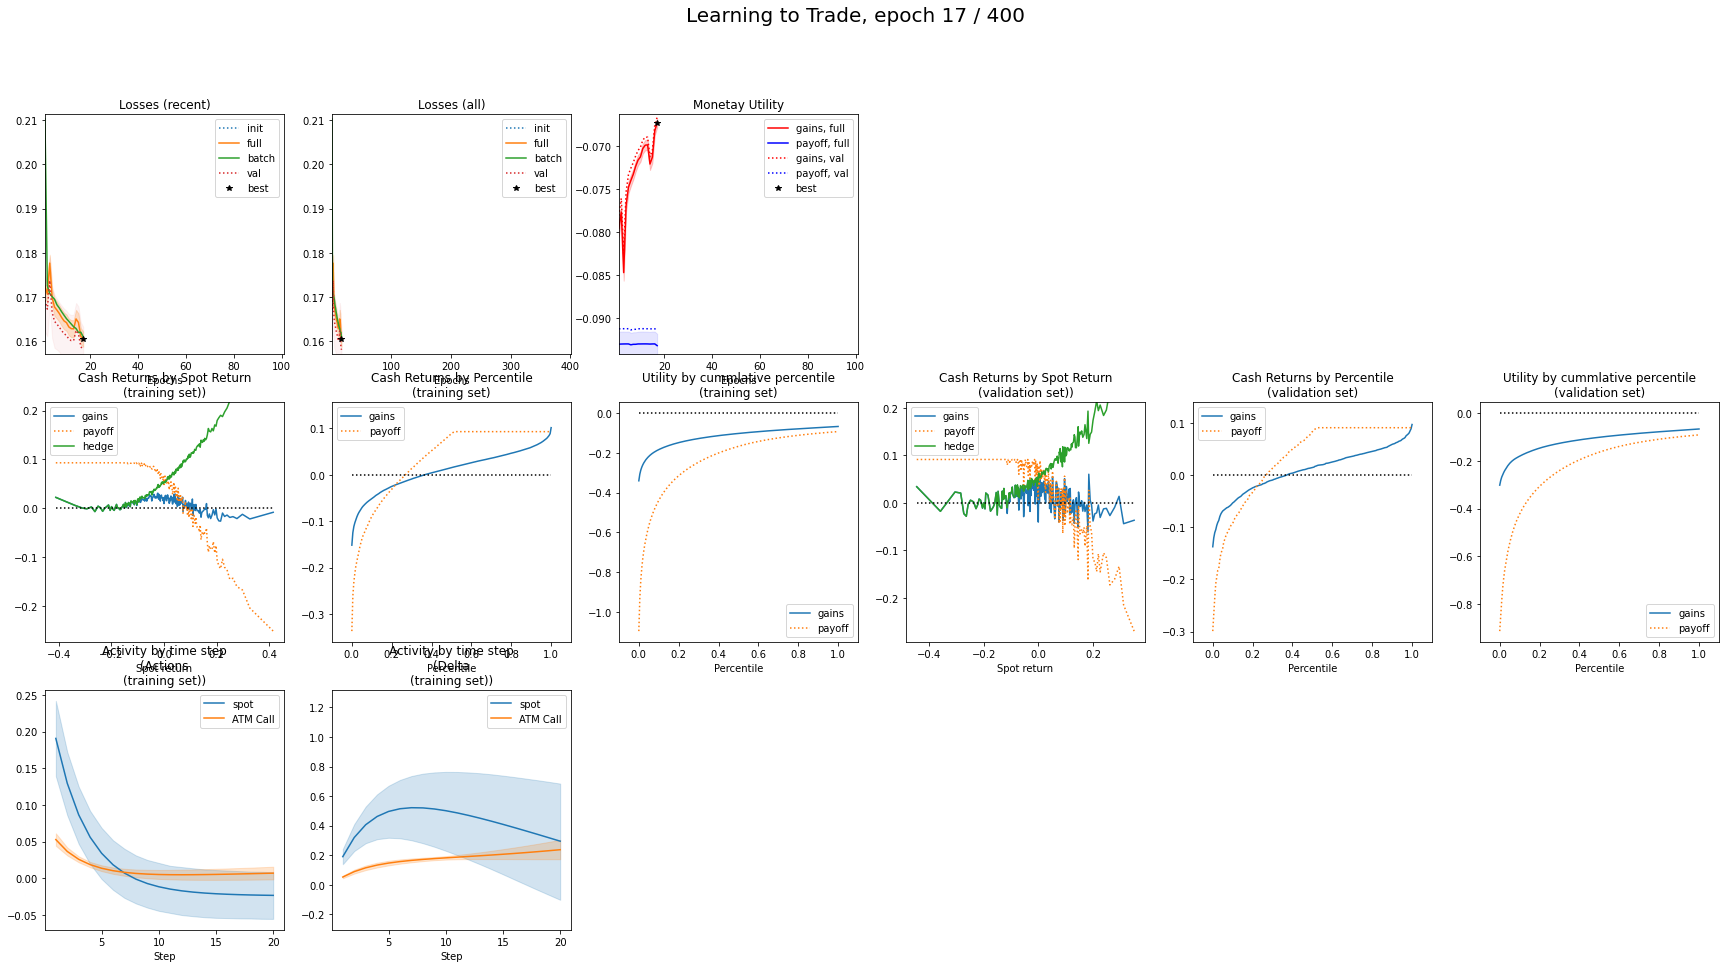

Training 16/400 epochs; 10000 samples; 1000 validation samples batch size 32 | initial loss 1.70836 (0.0358237), full 0.161139 (0.00183845), best 0.161139 (0.0358237), batch 0.162026, val 0.158753 (0.00552612). Best batch 15 | time elapsed 2:05; estimated time remaining 50:12  

In [ ]:
# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = False
# gym
config.gym.objective.utility = "exp2"
config.gym.objective.lmbda = 10.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.train.run_eagerly = False
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in simple Stochastic Volatility"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()
